> **DO NOT EDIT IF INSIDE `tsds` folder** 

# Week 6: Networks 2


*Wednesday, March 13th, 2019*

Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, but we can also use the network as a substrate on which to model phenomena and simulate processes. Some systems may have clusters: we can discover those by employing *community detection* algorithms. Other systems may be perfect for simulating how diseases spread. This week we will explore these two concepts. You will learn:

* How a popular community detection algorithm works.
* How null models are used in networks.
* How to simulate information/epidemic spreading on a network.

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [39]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`

## Exercises

### Part 1: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 6.1.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I tend to think of it as a program. Since all math can be implemented in code, all math can be broken into parts, where each part has it's own little job to perform. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
5. The sum term is normalized by $2m$. Why exactly $2m$?
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.


> **Ex. 6.1.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below.

In [2]:
import numpy as np

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    # Your beautiful code goes here

In [3]:
def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        label : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float (> 0)
    """
    _sum = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if c[i] == c[j]:
                _sum += A[i, j] - np.sum(A[i, :]) * np.sum(A[j, :]) * 1. / np.sum(A)
    return _sum / np.sum(A)

modularity(A, c)

0.12244897959183675

> **Ex. 6.1.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the networks with node colors that correspond to community, so you can see what is optimal.*

#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does't tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

> **Ex. 6.1.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`.

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 5.2.4**.

In [30]:
data = pd.read_csv(
    "../5_networks1/facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

data.head(10)

,user1,user2,timestamp
0,28,28,1095135831
1,1015,1017,1097725406
2,959,959,1098387569
3,991,991,1098425204
4,1015,1017,1098489762
5,1015,1017,1098673897
6,3368,3368,1098755376
7,14752,14736,1099526971
8,1015,1017,1099602800
9,1531,1080,1099889279


In [34]:
def get_network_slice(t0, t1):
    data_t = data.loc[data.timestamp.between(t0, t1)]
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')
    return nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.DiGraph)

G_t = get_network_slice(data.timestamp.max() - 86400 * 365, data.timestamp.max())

# Threshold edge weight at 1
G_t.remove_edges_from([e for e in G_t.edges(data=True) if e[2]['weight'] <= 1])

# Threshold node strength at 2
thr = 10
num_nodes = len(G_t)
num_edges = len(G_t.edges())
while len([n for n in G_t.nodes() if G_t.degree(n, weight='weight') < thr]) > 0:
    G_t.remove_nodes_from([n for n in G_t.nodes() if G_t.in_degree(n, weight='weight') < thr])
    G_t.remove_nodes_from([n for n in G_t.nodes() if G_t.out_degree(n, weight='weight') < thr])
    print("removed", num_nodes - len(G_t), "nodes and", num_edges - len(G_t.edges()), "edges")
    num_nodes = len(G_t)
    num_edges = len(G_t.edges())

print("final graph has:")
print("nodes", len(G_t))
print("edges", len(G_t.edges()))

G_t = nx.Graph(G_t)

removed 38134 nodes and 51858 edges
removed 1271 nodes and 4803 edges
removed 222 nodes and 906 edges
removed 44 nodes and 188 edges
final graph has:
nodes 4726
edges 23340


> **Ex. 6.1.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

In [35]:
# [This will be in assignment 2]

> **Ex. 6.1.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://github.com/benmaier/netwulf#attributes)'s an example of how to use `netwulf` with labels. Also, fiddle around with the layout a little it always makes the network look nicer.*

In [44]:
# [This will be in assignment 2]

### Part 2: Contagion

If you have a network where links represent interactions that can happen between actors, then you can use that as a model universe for simulating the spreading of a disease, a rumor, or some piece of information. There's a whole subfield of Network Science called Contagion Theory which deals with this, but the fundamental idea is actually quite simple:

> Nodes that are connected can pass an epidemy/information with some probability and eventually things stabilize.

You can then make this more nuanced and step into the realm of *complex contagion* by *inventing* that nodes can only be infected if multiple neighbors are infected, that they can be cured and become resistent/susceptible with some probability, that they may die and exit the simulation creating a void in the network, that becoming infected makes them change their links, that godzilla walks through the door and eats everyone—the possibilities are endless and you decide which rules exist in the simulation universe.

Generally speaking, there are three four classes of spreading models:
* *Susceptible-Infected (SI)*: Nodes are susceptible at start, and once they are infected they never recover. This models spreading of unforgetable information, or diseases that people get and pass on, and never recover from (like HIV, herpes, etc.).
* *Susceptible-Infected-Susceptible (SIS)*: Nodes are susceptible, then get infected and stay infected for some time, then get susceptible again, an the cycle continues. This could model things like the flu which comes and goes and you get and recover from over and over again.
* *Susceptible-Infected-Resistant (SIR)*: Nodes become infected and after some time they gain resistance so that they can niether become infected nor spread disease/information further. Once they are resistant they are essentially "removed" from the network, so this type of model works for diseases where people recover and gain resistance as well as ones that kill people, as niether type of person can pass whatever is passed around.
* *Susceptible-Infected-Resistant-Susceptible (SIRS)*: Probably self-explanatory.

> **Ex. 6.2.1**: Computational biologist/physicist and all around cool guy, Dirk Brockmann,
makes interactive articles called *Explorables* that introduce ideas in complexity science. Read/play with
[his explorable](http://www.complexity-explorables.org/explorables/neighbors/) on targeted vaccination to mitigate epidemic spreading in the real world and answer the
following questions:
> 1. In the BA network, roughly what percentage of the population do you have to vaccinate with **strategy A** to only get around 10
infected individuals? What about **startegy B** and **strategy C**?
> 2. **strategy A** and **strategy C** are both entirely random, but one is much more effective than the other. Explain
why. What clever idea is **strategy C** employing?
> 3. Why is this effect larger in the BA network than in the ER network?

1. Strategy A: 70-80%, Strategy B: 15-20%, Strategy C: 40-50%.

2. As per the "friendhip paradox" your friends have more friends than you. Therefore, when passing the vaccine to a random friend, because there are a few very well connected nodes, these guys are likely to end up with a vaccine on hand and then your vaccination strategy will look more like strategy B.

3. In the ER network there are not so many well connected nodes, so passing the vaccine randomly around does not so much increase the probability that well connected nodes will end up with vacciens (though it does have a small effect).

> **Ex. 6.2.2**: Choose one of these two explorables ([1](http://www.complexity-explorables.org/explorables/herd/) or [2](http://www.complexity-explorables.org/explorables/epidemonic/)) read/play with and understand it, and explain in your own words what phenomenon it communicates.

> **Ex. 6.2.1**: The simplest spreading process is the *SI* model. Below I have implemented such a simulation.
1. Comment the code abundantly, explaining what's happing at each step.
2. Adapt the code and make a plot of the fraction of infected over time. You may have to restart it a couple of time to make sure patient 0 is someone connected to the rest of the population.
3. Extend the code such after a variable number of timesteps `T_I` infected nodes become susceptible again. Set `T_I = 10` to begin with and plot the fraction of infected over time for 200 timesteps. Does the result make sense? Comment on what you see.

In [418]:
import numpy as np

p_I = 0.1
n_iter = 200
G = yournetwork

I = set()
S = set(G.nodes())

patient0 = np.random.choice(list(S))

I.add(patient0)
S.remove(patient0)

for t in range(n_iter):
    for infected_node in list(I):
        neighbors = G.neighbors(infected_node)
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I])
        I |= infected_neighbors
        S -= infected_neighbors

In [58]:
import numpy as np

p_I = 0.1
n_iter = 200
G = G_t.copy()

I = set()
S = set(G.nodes())
N = len(S)

patient0 = np.random.choice(list(S))

I.add(patient0)
S.remove(patient0)

y = []
for t in range(n_iter):
    for infected_node in list(I):
        neighbors = G.neighbors(infected_node)
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I])
        I |= infected_neighbors
        S -= infected_neighbors
    y.append(len(I) / N)

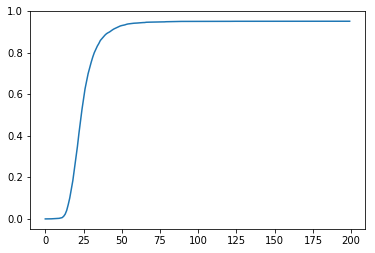

In [59]:
plt.plot(y)

In [125]:
from collections import defaultdict

p_I = 0.1
n_iter = 200
G = G_t.copy()

I = set()
S = set(G.nodes())
N = len(S)
I_T = 10

patient0 = np.random.choice(list(S))

I.add(patient0)
S.remove(patient0)

I_countup = defaultdict(int)
I_countup[patient0] = 0

y = []
for t in range(n_iter):
    for infected_node in list(I):
        neighbors = G.neighbors(infected_node)
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I])
        [n for n in infected_neighbors if I_countup[n]]
        I |= infected_neighbors
        S -= infected_neighbors
        
    for n in list(I_countup.keys()):
        I_countup[n] += 1
        if I_countup[n] == I_T:
            del I_countup[n]
            I.remove(n)
            S.add(N)
        
    y.append(len(I_countup) / N)

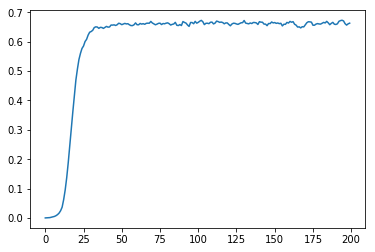

In [126]:
plt.plot(y)